# Consultas 

## Definição da Constelação de Fatos

**Tabelas de dimensão**

- dim_data (data_pk, data_completa, data_dia, data_mes, data_semestre, data_ano)
- dim_localidade (localidade_pk, latitude, longitude, cidade, estado, regiao, pais)
- dim_tipo_cancer (tipo_cancer_pk, tipo_cancer, mortalidade, taxa_incidencia_total)
- dim_faixa_etaria (faixa_pk, faixa_idade, idade_min, idade_max, id_idade)
- dim_metrica (metrica_pk, tipo_metrica)
- dim_sexo (sexo_pk, sexo)

**Tabelas de fatos**

- fato_cancer (ano_pk, estado_pk, tipo_cancer_pk, sexo_pk, faixa_pk, metrica_pk, obitos_cancer, incidencia_cancer, prevalencia_cancer)
- fato_clima (data_pk, localidade_pk, temperatura_media, temperatura_max, temperatura_min, radiacao_uv, radiacao_uva, radiacao_uvb, precipitacao)

**Views**

- vw_cidade (localidade_pk, latitude, longitude, clima_cidade, clima_estado, clima_regiao, clima_pais)
- vw_estado (estado_pk, cancer_regiao, cancer_pais)
- vw_dia (data_pk, clima_data_completa, clima_dia, clima_mes, clima_semestre, clima_ano)
- vw_ano (ano_pk, cancer_ano, cancer_decada)

In [29]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')


In [30]:
import geopandas as gpd

shapefile_path = 'data/bcim_2016_21_11_2018.gpkg' 
info_brasil = gpd.read_file(shapefile_path, layer='lim_unidade_federacao_a')

In [31]:
info_brasil.columns

Index(['nome', 'nomeabrev', 'geometriaaproximada', 'sigla', 'geocodigo',
       'id_produtor', 'id_elementoprodutor', 'cd_insumo_orgao',
       'nr_insumo_mes', 'nr_insumo_ano', 'tx_insumo_documento', 'geometry'],
      dtype='object')

-------

# Roll-Up

### Qual seria a Precipitação média de cada Estado?

In [32]:
query = """
SELECT
    a.estado, AVG(f.precipitacao) AS media_precipitacao
FROM
    fato_clima f 
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
GROUP BY
    a.estado
ORDER BY
    media_precipitacao DESC;
"""

df = pd.read_sql(query, engine)
df.head()

,estado,media_precipitacao
0,Amazonas,6.065025
1,Pará,5.862740
2,Amapá,5.826249
3,Acre,4.840113
4,Santa Catarina,4.462997


In [33]:

info_brasil.rename({'nome': 'estado'}, axis=1, inplace=True)
precipitacao_estados = info_brasil.merge(df, on='estado', how='left')


<Axes: >

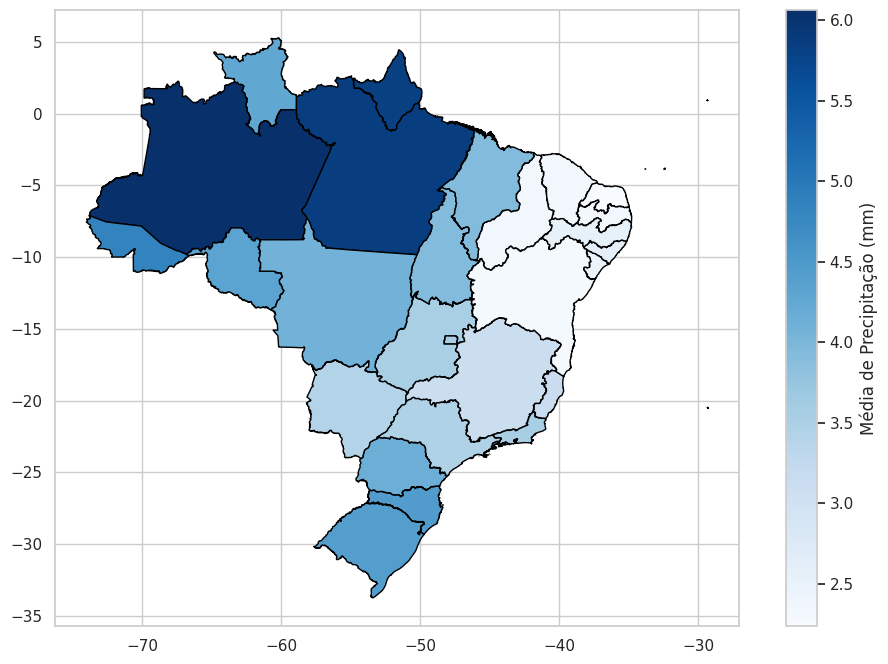

In [34]:
precipitacao_estados.plot(column='media_precipitacao', cmap='Blues', legend=True, figsize=(12, 8), edgecolor='black', legend_kwds={"label": "Média de Precipitação (mm)", "orientation": "vertical"},)

### Qual a temperatura média de uma região?

In [35]:
query = """
SELECT
    a.estado, AVG(f.temperatura_media) AS temperatura_media
FROM
    fato_clima f 
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
GROUP BY
    a.estado
ORDER BY
    temperatura_media DESC;
"""

df = pd.read_sql(query, engine)
df

,estado,temperatura_media
0,Piauí,27.852664
1,Maranhão,27.382270
2,Ceará,27.060568
3,Rio Grande do Norte,27.025015
4,Tocantins,26.859412
5,Pará,26.842881
6,Roraima,26.749561
7,Amapá,26.468063
8,Amazonas,26.460517
9,None,26.436766


<Axes: >

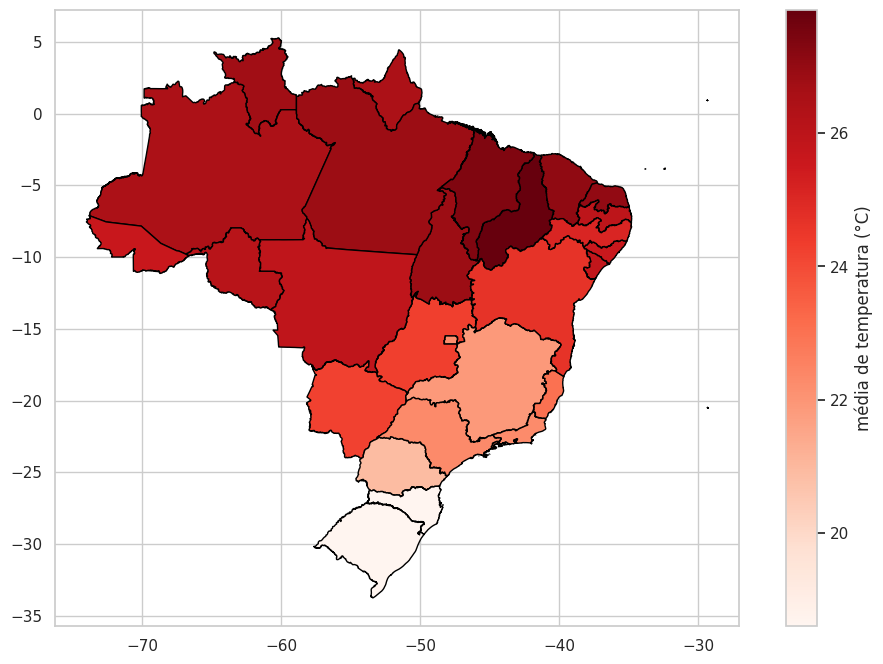

In [36]:
precipitacao_estados = info_brasil.merge(df, on='estado', how='left')
precipitacao_estados.plot(column='temperatura_media',
                        cmap='Reds',
                        legend=True,
                        figsize=(12, 8),
                        edgecolor='black',
                        legend_kwds={"label": "média de temperatura (°C)",
                                      "orientation": "vertical"})

### Qual o número total de casos de câncer de pele por região no Brasil?

In [37]:
query = """
SELECT
    e.cancer_regiao,
    SUM(f.obitos_cancer) AS total_obitos,
    SUM(f.incidencia_cancer) AS total_incidencia,
    SUM(f.prevalencia_cancer) AS total_prevalencia
FROM
    fato_cancer f
JOIN
    vw_estado e ON e.estado_pk = f.estado_pk
JOIN
    dim_metrica m ON m.metrica_pk = f.metrica_pk
WHERE
    m.tipo_metrica LIKE 'Número'
GROUP BY
    e.cancer_regiao
ORDER BY
    total_incidencia DESC;
"""


df = pd.read_sql(query, engine)
df.head()

,cancer_regiao,total_obitos,total_incidencia,total_prevalencia
0,Nordeste,47714.558,1652056.555,419009.182
1,Sudeste,11339.346,489875.575,104956.946
2,Sul,13414.587,480629.701,120075.678
3,Centro-Oeste,4763.532,276589.327,56955.111
4,Norte,8280.172,166336.887,55582.711


/tmp/ipykernel_1189580/1596714291.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cancer_regiao', y='total_obitos', data=df, palette='Reds_r', ax=axs[0])
/tmp/ipykernel_1189580/1596714291.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cancer_regiao', y='total_incidencia', data=df, palette='Blues_r', ax=axs[1])
/tmp/ipykernel_1189580/1596714291.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cancer_regiao', y='total_prevalencia', data=df, palette='Greens_r', ax=axs[2])


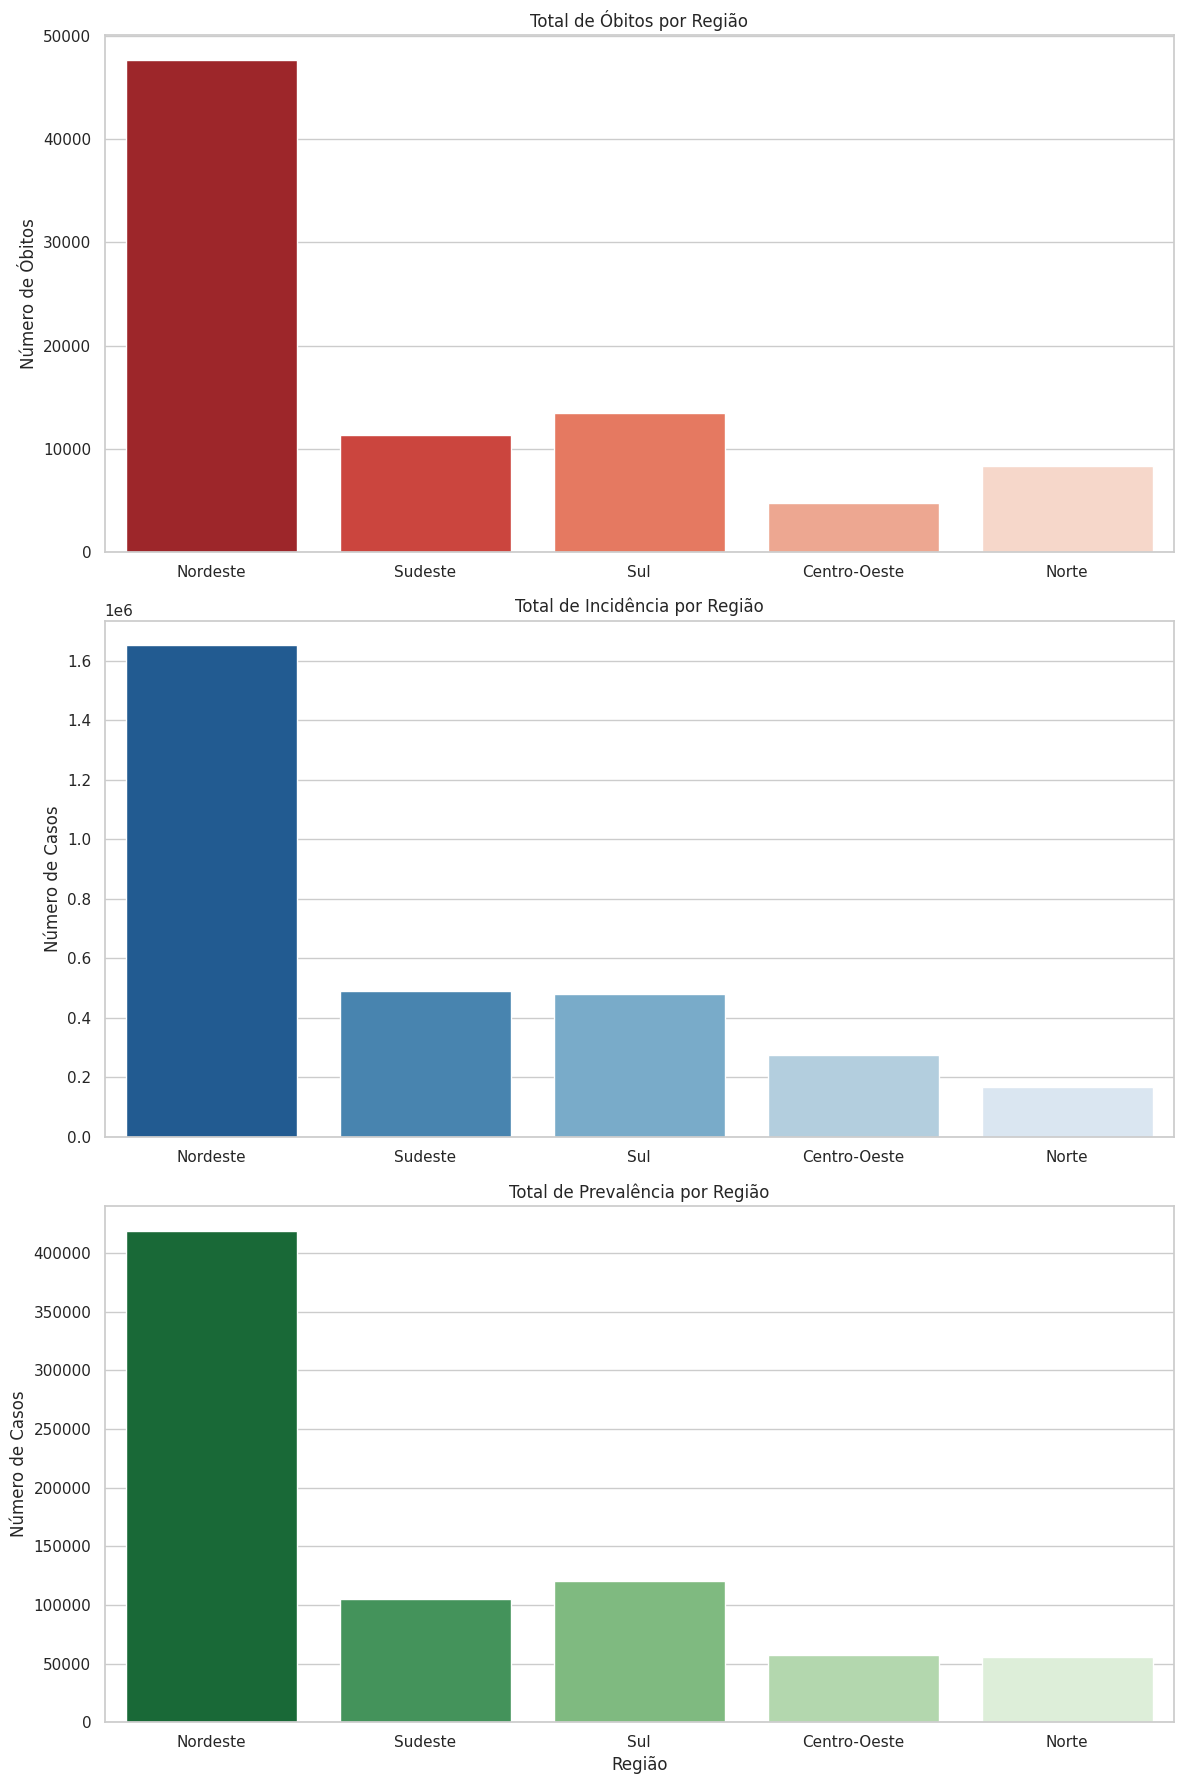

In [38]:
df = pd.DataFrame(df)

sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

sns.barplot(x='cancer_regiao', y='total_obitos', data=df, palette='Reds_r', ax=axs[0])
axs[0].set_title('Total de Óbitos por Região')
axs[0].set_xlabel('')
axs[0].set_ylabel('Número de Óbitos')

sns.barplot(x='cancer_regiao', y='total_incidencia', data=df, palette='Blues_r', ax=axs[1])
axs[1].set_title('Total de Incidência por Região')
axs[1].set_xlabel('')
axs[1].set_ylabel('Número de Casos')

sns.barplot(x='cancer_regiao', y='total_prevalencia', data=df, palette='Greens_r', ax=axs[2])
axs[2].set_title('Total de Prevalência por Região')
axs[2].set_xlabel('Região')
axs[2].set_ylabel('Número de Casos')

plt.tight_layout()
plt.show()

----

# Slice and Dice

### Qual foi a temperatura média da cidade X entre o ano Y e o ano Z?

In [39]:
CIDADE = 'São Paulo'
ANO_INICIAL = 2010
ANO_FINAL = 2020

query = f"""
SELECT
    a.cidade,
    AVG(f.temperatura_media) AS temperatura_media
FROM
    fato_clima f
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
JOIN
    dim_data b ON b.data_pk = f.data_pk
WHERE
    b.data_ano BETWEEN {ANO_INICIAL} AND {ANO_FINAL}
    AND a.cidade = '{CIDADE}'
GROUP BY
    a.cidade
"""

df = pd.read_sql(query, engine)
df.head()

,cidade,temperatura_media
0,São Paulo,19.810035


### Qual a taxa de câncer de pele em pessoas do sexo X com Y anos até Z anos de idade?

In [40]:
SEXO = 'Feminino'
IDADE_INICIAL = 20
IDADE_FINAL = 60


query = f"""
SELECT 
    b.faixa_etaria,
    AVG(f.incidencia_cancer) AS total_incidencia
FROM
    fato_cancer f
JOIN
    dim_sexo a ON a.sexo_pk = f.sexo_pk
JOIN
    dim_faixa_etaria b ON b.faixa_pk = f.faixa_pk
JOIN 
    dim_metrica c ON c.metrica_pk = f.metrica_pk
WHERE
    a.sexo = '{SEXO}'
    AND c.tipo_metrica = 'Taxa'
    AND b.idade_min >= {IDADE_INICIAL}
    AND b.idade_max <= {IDADE_FINAL}
GROUP BY
    b.faixa_etaria
ORDER BY
    b.faixa_etaria ASC;
"""


df = pd.read_sql(query, engine)
df

,faixa_etaria,total_incidencia
0,20-24,1.406052
1,25-29,2.537994
2,30-34,4.870052
3,35-39,8.430008
4,40-44,14.229566
5,45-49,22.274817
6,50-54,31.524685
7,55-59,41.992861


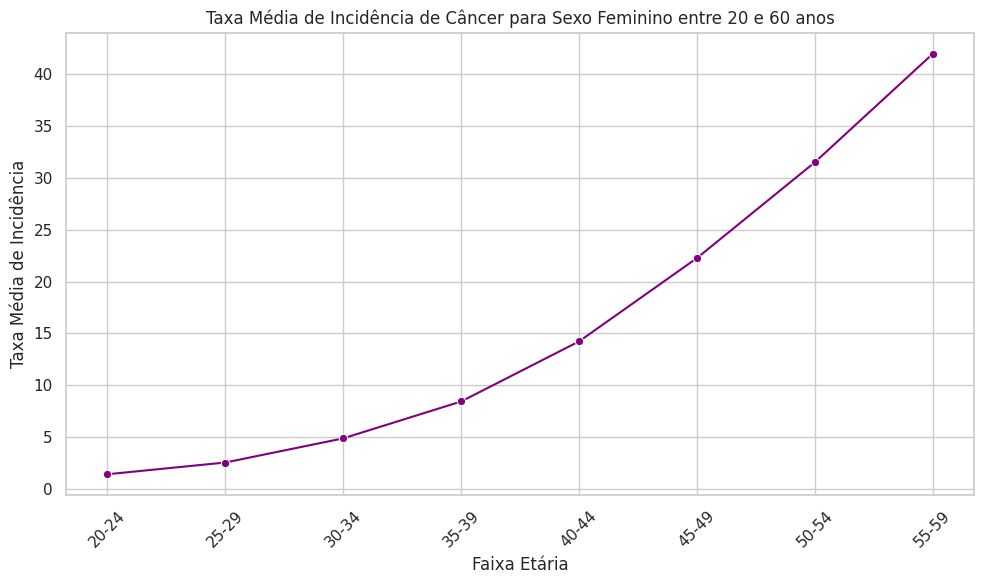

In [41]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='faixa_etaria', y='total_incidencia', marker='o', color='purple')

plt.title(f'Taxa Média de Incidência de Câncer para Sexo {SEXO} entre {IDADE_INICIAL} e {IDADE_FINAL} anos')
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa Média de Incidência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Qual a soma mensal de radiação UVA e UVB em uma cidade X em um ano Y?

In [42]:
ANO = '2015'

query = f"""
SELECT
    a.cidade,
    a.latitude,
    a.longitude,
    AVG(f.radiacao_uva) AS media_uva,
    AVG(f.radiacao_uvb) AS media_uvb
FROM 
    fato_clima f
JOIN dim_localidade a ON a.localidade_pk = f.localidade_pk
JOIN dim_data b ON b.data_pk = f.data_pk
WHERE 
    b.data_ano = {ANO}
GROUP BY 
    a.cidade,a.latitude,a.longitude
ORDER BY
    media_uvb    
"""

df = pd.read_sql(query, engine)
df.head()

,cidade,latitude,longitude,media_uva,media_uvb
0,Pedro Osório,-31.8642,-52.8184,0.914438,0.023534
1,Turuçu,-31.4173,-52.1706,0.914438,0.023534
2,Canguçu,-31.3960,-52.6783,0.914438,0.023534
3,Cristal,-31.0046,-52.0436,0.914438,0.023534
4,Morro Redondo,-31.5887,-52.6261,0.914438,0.023534


In [43]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df['media_uva_norm'] = normalize(df['media_uva'])
df['media_uvb_norm'] = normalize(df['media_uvb'])


gradient = {
    0.0: 'blue',
    0.4: 'cyan',
    0.6: 'lime',
    0.8: 'yellow',
    1.0: 'red'
}

m = folium.Map(location=[-15.7801, -47.9292], zoom_start=5)
heat_data_uva = [[row['latitude'], row['longitude'], row['media_uva_norm']] for _, row in df.iterrows()]
HeatMap(heat_data_uva, radius=25, blur=20, max_zoom=10, gradient=gradient).add_to(m)
m

In [44]:
gradient = {
    0.80: '#440154',
    0.87: '#3b528b',
    0.90: '#21908d',
    0.91: '#fde725',
    1.0: '#fefc5c'
}

max_val = 0.95


m_uvb = folium.Map(location=[-15.7801, -47.9292], zoom_start=5)
heat_data_uvb = [[row['latitude'], row['longitude'], row['media_uvb_norm']] for _, row in df.iterrows()]
HeatMap(heat_data_uvb, radius=15, blur=15, gradient=gradient, max_zoom=10).add_to(m_uvb)
m_uvb

---

# Pivot

### Qual o número de óbitos por câncer de pele por faixa etária para cada sexo?

In [45]:
query = f"""
SELECT
    b.faixa_etaria,
    SUM(CASE WHEN a.sexo = 'Masculino' THEN f.obitos_cancer ELSE 0 END) AS obitos_masculino,
    SUM(CASE WHEN a.sexo = 'Feminino' THEN f.obitos_cancer ELSE 0 END) AS obitos_feminino
FROM 
    fato_cancer f
JOIN dim_sexo a ON a.sexo_pk = f.sexo_pk
JOIN dim_faixa_etaria b ON b.faixa_pk = f.faixa_pk
JOIN dim_metrica c ON c.metrica_pk = f.metrica_pk
WHERE 
    c.tipo_metrica = 'Número'
GROUP BY 
    b.faixa_etaria, b.idade_min
ORDER BY 
    b.idade_min DESC;
"""

df = pd.read_sql(query, engine)
df


,faixa_etaria,obitos_masculino,obitos_feminino
0,95+,1008.301,1920.435
1,90-94,2343.283,3120.153
2,85-89,4006.079,4310.402
3,80-84,5007.568,4234.156
4,75-79,5558.569,3837.608
5,70-74,5681.916,3029.049
6,65-69,5524.390,2646.856
7,60-64,5162.458,2505.303
8,55-59,4427.815,2303.969
9,50-54,3609.124,2062.307


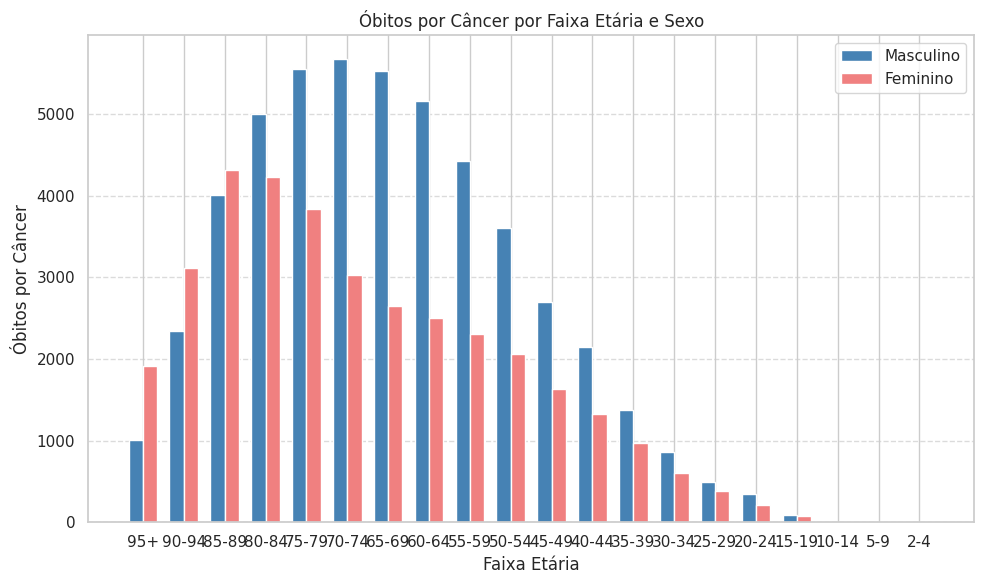

In [46]:

x = df['faixa_etaria']
x_indexes = range(len(x))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar([i - width/2 for i in x_indexes], df['obitos_masculino'], width=width, label='Masculino', color='steelblue')
plt.bar([i + width/2 for i in x_indexes], df['obitos_feminino'], width=width, label='Feminino', color='lightcoral')

plt.xticks(ticks=x_indexes, labels=x)
plt.xlabel('Faixa Etária')
plt.ylabel('Óbitos por Câncer')
plt.title('Óbitos por Câncer por Faixa Etária e Sexo')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## “Qual emissão de radiação UVB por semestre?”

In [47]:
query = f"""
SELECT
    a.cidade,
    a.estado,
    AVG(CASE WHEN d.data_semestre = 0 THEN f.radiacao_uvb END) AS semestre_0,
    AVG(CASE WHEN d.data_semestre = 1 THEN f.radiacao_uvb END) AS semestre_1
FROM 
    fato_clima f
JOIN dim_data d ON d.data_pk = f.data_pk
JOIN dim_localidade a ON a.localidade_pk = f.localidade_pk
WHERE d.data_ano = 2020
GROUP BY a.cidade, a.estado
ORDER BY a.cidade;
"""

df = pd.read_sql(query, engine)
df.head()


,cidade,estado,semestre_0,semestre_1
0,Abadia de Goiás,Goiás,0.037143,0.038750
1,Abadia dos Dourados,Minas Gerais,0.034560,0.037120
2,Abadiânia,Goiás,0.036813,0.038478
3,Abaeté,Minas Gerais,0.033077,0.035163
4,Abaetetuba,Pará,0.034341,0.038804


---

# Drill-Across

### Qual a média anual de incidência de raios UV e da taxa de câncer de pele em uma determinada região do Brasil?

In [48]:

query = f"""

WITH clima AS (
    SELECT 
        a.clima_ano,
        SUM(f_clima.radiacao_uv) AS uv_media,
        SUM(f_clima.radiacao_uva) AS uva_media,
        SUM(f_clima.radiacao_uvb) AS uvb_media
    FROM
        fato_clima f_clima 
    JOIN
        vw_dia a ON f_clima.data_pk = a.data_pk
    GROUP BY
        a.clima_ano
),
cancer AS (
    SELECT
        a.cancer_ano,
        SUM(f_cancer.obitos_cancer) AS obitos_cancer
    FROM
        fato_cancer f_cancer
    JOIN
        dim_metrica m ON m.metrica_pk = f_cancer.metrica_pk
    JOIN
        vw_ano a ON a.ano_pk = f_cancer.ano_pk
    WHERE
        m.tipo_metrica LIKE 'Número'
    GROUP BY
        a.cancer_ano
)
SELECT
    clima.clima_ano,
    clima.uv_media,
    clima.uva_media,
    clima.uvb_media,
    cancer.obitos_cancer,
    (clima.uv_media * cancer.obitos_cancer) AS obitos_x_uv,
    (clima.uva_media * cancer.obitos_cancer) AS obitos_x_uva,
    (clima.uvb_media * cancer.obitos_cancer) AS obitos_x_uvb
FROM
    clima
JOIN
    cancer ON clima.clima_ano = cancer.cancer_ano
ORDER BY
    clima.clima_ano;
"""


df = pd.read_sql(query, engine)
df

,clima_ano,uv_media,uva_media,uvb_media,obitos_cancer,obitos_x_uv,obitos_x_uva,obitos_x_uvb
0,2001,4030783.71,2372624.51,67410.21,2763.838,1.114043e+10,6.557550e+09,1.863109e+08
1,2002,4062328.18,2368361.63,67740.68,2920.224,1.186291e+10,6.916146e+09,1.978180e+08
2,2003,4061847.82,2390256.61,67990.65,2939.557,1.194003e+10,7.026296e+09,1.998624e+08
3,2004,4036758.50,2361985.35,67415.85,2995.714,1.209297e+10,7.075833e+09,2.019586e+08
4,2005,4007137.58,2338554.41,66841.62,3143.463,1.259629e+10,7.351159e+09,2.101142e+08
5,2006,4139778.37,2374361.58,68880.96,3302.559,1.367186e+10,7.841469e+09,2.274834e+08
6,2007,4127184.39,2380638.41,68677.62,3435.839,1.418034e+10,8.179490e+09,2.359652e+08
7,2008,4096312.64,2375414.34,68301.49,3574.713,1.464314e+10,8.491425e+09,2.441582e+08
8,2009,4084148.01,2337691.75,67993.85,3713.763,1.516756e+10,8.681633e+09,2.525130e+08
9,2010,4064382.51,2367808.62,67695.69,3862.052,1.569686e+10,9.144600e+09,2.614443e+08


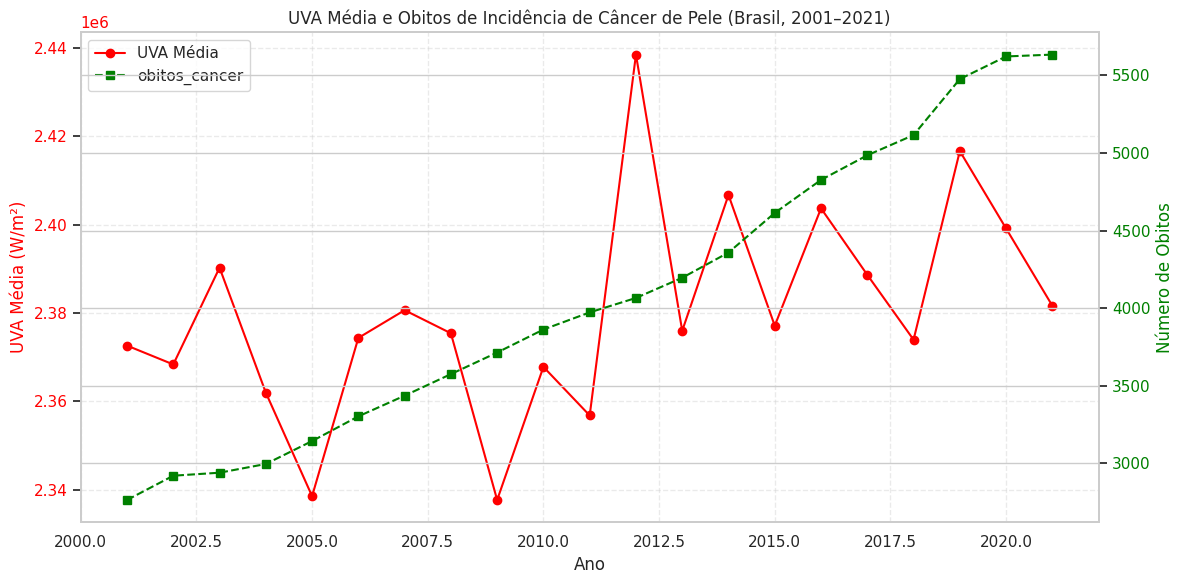

In [49]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo Y esquerdo: UVA média
ax1.plot(df['clima_ano'], df['uva_media'], color='red', marker='o', label='UVA Média')
ax1.set_xlabel('Ano')
ax1.set_ylabel('UVA Média (W/m²)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, linestyle='--', alpha=0.4)

# Eixo Y direito: Taxa de Incidência
ax2 = ax1.twinx()
ax2.plot(df['clima_ano'], df['obitos_cancer'], color='green', marker='s', linestyle='--', label='obitos_cancer')
ax2.set_ylabel('Número de Obitos', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Título e legenda combinada
plt.title('UVA Média e Obitos de Incidência de Câncer de Pele (Brasil, 2001–2021)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

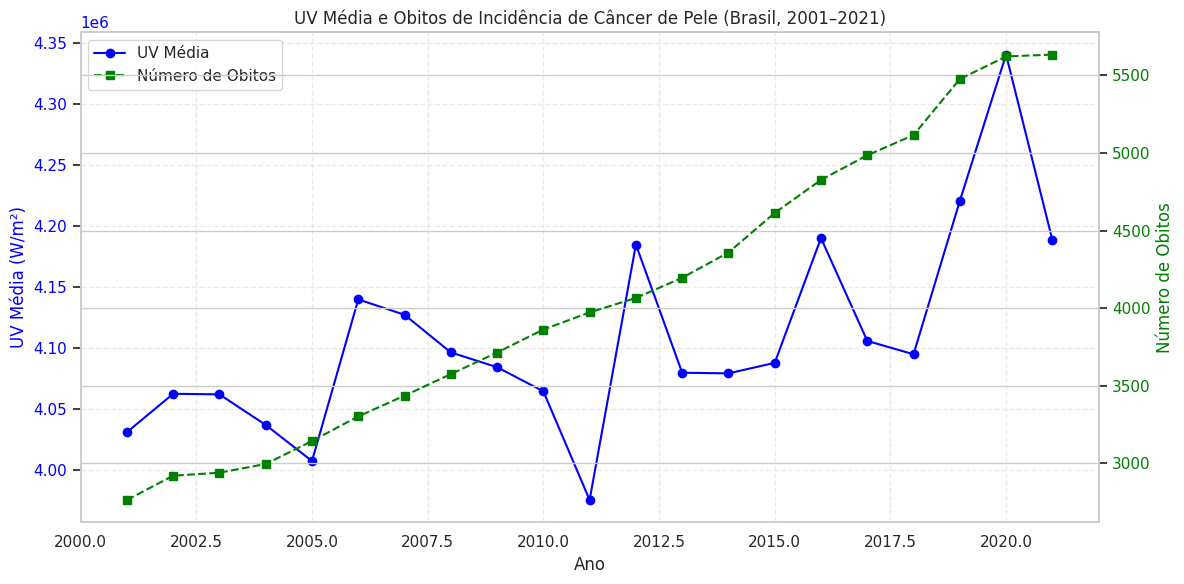

In [50]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df['clima_ano'], df['uv_media'], color='blue', marker='o', label='UV Média')
ax1.set_xlabel('Ano')
ax1.set_ylabel('UV Média (W/m²)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.4)


ax2 = ax1.twinx()
ax2.plot(df['clima_ano'], df['obitos_cancer'], color='green', marker='s', linestyle='--', label='Número de Obitos')
ax2.set_ylabel('Número de Obitos', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('UV Média e Obitos de Incidência de Câncer de Pele (Brasil, 2001–2021)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


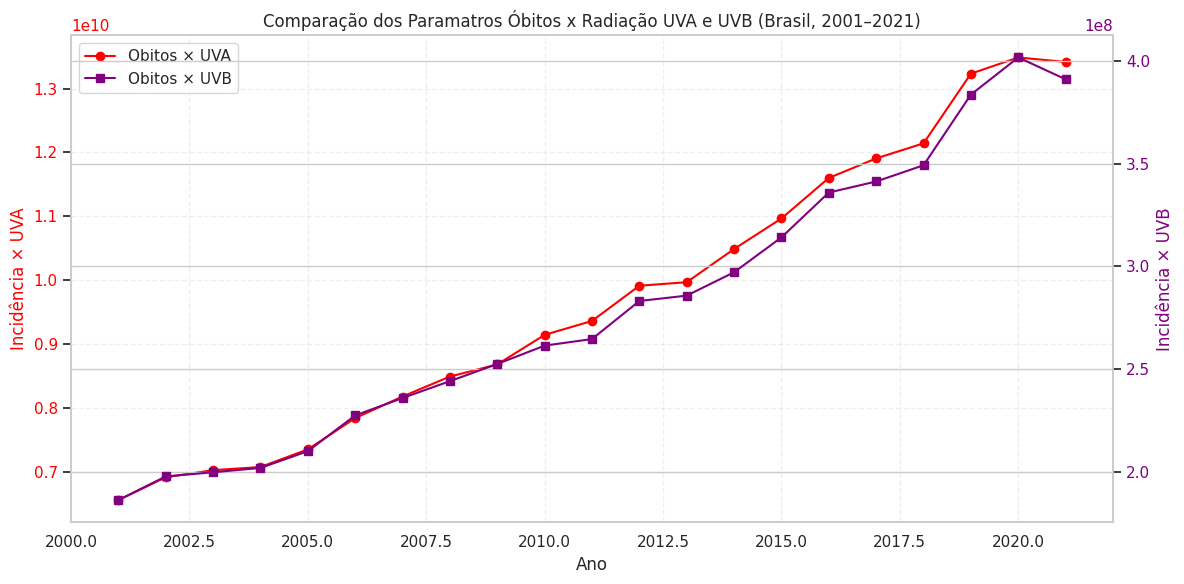

In [51]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df['clima_ano'], df['obitos_x_uva'], color='red', marker='o', label='Obitos × UVA')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Incidência × UVA', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, linestyle='--', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(df['clima_ano'], df['obitos_x_uvb'], color='purple', marker='s', label='Obitos × UVB')
ax2.set_ylabel('Incidência × UVB', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Comparação dos Paramatros Óbitos x Radiação UVA e UVB (Brasil, 2001–2021)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

### Qual a temperatura média e a incidência de câncer de pele nas diferentes regiões brasileiras ao longo dos anos?

In [52]:

query = f"""

WITH clima AS (
SELECT 
    a.clima_ano,
    AVG(f_clima.temperatura_media) AS temperatura_media
FROM
    fato_clima f_clima 
JOIN
    vw_dia a ON f_clima.data_pk = a.data_pk
JOIN
    vw_cidade b ON b.localidade_pk = f_clima.localidade_pk
GROUP BY
    a.clima_ano
),
cancer AS (
SELECT
    a.cancer_ano,
    AVG(f_cancer.incidencia_cancer) AS taxa_incidencia
FROM
    fato_cancer f_cancer
JOIN
    vw_estado e ON e.estado_pk = f_cancer.estado_pk
JOIN
    dim_metrica m ON m.metrica_pk = f_cancer.metrica_pk
JOIN
    vw_ano a ON a.ano_pk = f_cancer.ano_pk
WHERE
    m.tipo_metrica LIKE 'Taxa'
GROUP BY
    a.cancer_ano
)

SELECT
    clima.clima_ano,
    clima.temperatura_media,
    cancer.taxa_incidencia,
    (cancer.taxa_incidencia * clima.temperatura_media) AS inc_x_temp
FROM
    clima
JOIN
    cancer ON clima.clima_ano = cancer.cancer_ano
ORDER BY
    clima_ano
"""


df = pd.read_sql(query, engine)
df

,clima_ano,temperatura_media,taxa_incidencia,inc_x_temp
0,2001,23.278090,77.250298,1798.239415
1,2002,23.468685,77.246834,1812.881568
2,2003,23.126043,77.185420,1784.993346
3,2004,22.799139,77.071694,1757.168229
4,2005,23.447748,77.005176,1805.597997
5,2006,23.093580,76.990858,1777.994524
6,2007,23.275010,77.104112,1794.598978
7,2008,22.926818,77.162078,1769.080929
8,2009,23.039500,77.112205,1776.626658
9,2010,23.230240,76.927483,1787.043861


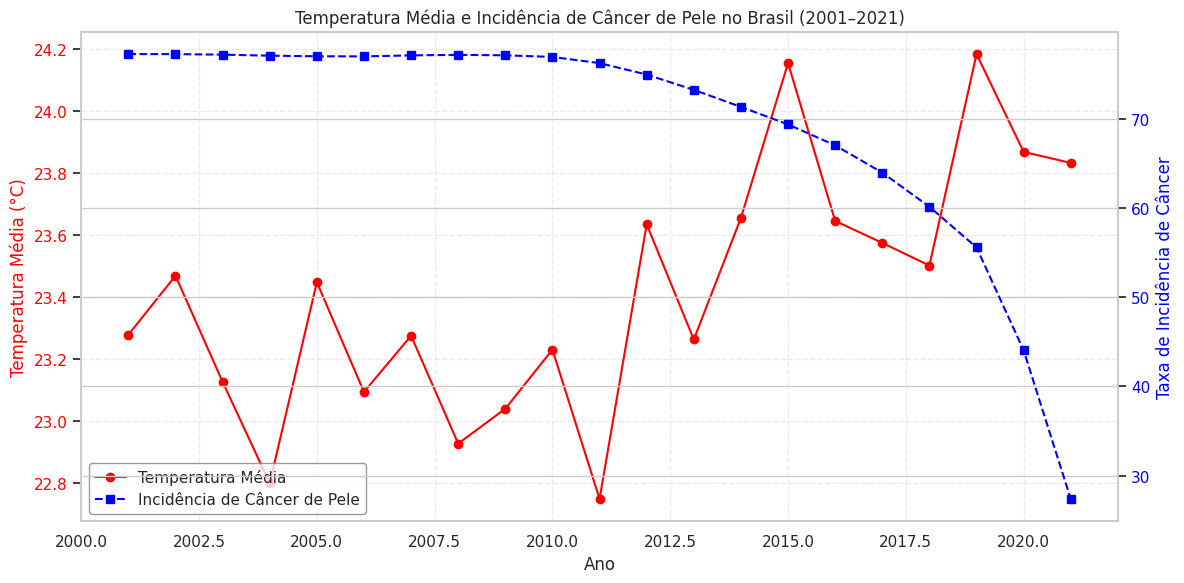

In [53]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df['clima_ano'], df['temperatura_media'], color='red', marker='o', label='Temperatura Média')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Temperatura Média (°C)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, linestyle='--', alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(df['clima_ano'], df['taxa_incidencia'], color='blue', marker='s', linestyle='--', label='Incidência de Câncer de Pele')
ax2.set_ylabel('Taxa de Incidência de Câncer', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Temperatura Média e Incidência de Câncer de Pele no Brasil (2001–2021)')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='lower left',  
    frameon=True,       
    facecolor='white',
    edgecolor='gray'
)

plt.tight_layout()
plt.show()